# 1. Enable ALOS-2 data processing to detect extension of oil palm plantations

First, install the packages required for data processing.If Anaconda is installed with administrative privileges, Jupyter Notebook must be run with administrative privileges.

In [ ]:
!conda install -c conda-forge rasterio matplotlib gdal geopandas -y

In this section, the following procedure illustrates the observation of oil palm plantation expansion and deforestation using ALOS-2/PALSAR2 data.

- Understand the relationship between features in multi-polarization (HH/HV) color composite imagery and land cover/land use seen in high-resolution imagery such as Google Earth.
- Practice Change Vector Analysis, a method for analyzing land cover and land use changes using two periods of observation data.

### Key learning objectives:
- 1.1 Basic of python for visualize ALOS-2 satellite images for tropical forest with oil palm plantation.
- 1.2 Visualization of ALOS-2/PALSAR-2 data using Python
- 1.3 Change detection analysis based on analysis of 2-time period data
- 1.4 Advantages and Uses of this Exercise Procedure


## 1.1. Basic of python for visualize ALOS-2 satellite images for tropical forest with oil palm plantation.
In this section, we cover the basic of using Python to visualize ALOS-2 satellite images of tropical forest with oil palm plantations. We will introduce libraries and functions for handling satellite data, creating color composites, and performing image enhancements. 

### 1.1.1. Understand ALOS-2 imagery
- Provide a brief introduction to the ALOS-2 imagery.

#### (Basic) [ALOS-2 (Advanced Land Observing Satellite-2)](https://www.eoportal.org/satellite-missions/alos-2#alos-2-advanced-land-observing-satellite-2-sar-mission--daichi-2)
Here is a brief summary of the ALOS-2 mission:
- Designed as the Advanced Land Observing Satellite-2 (ALOS-2), also known as Daichi-2, for high-resolution land observation using radar.
- Equipped with PALSAR-2, an enhanced radar sensor offering high-resolution imaging and day-and-night, all-weather observation capabilities.
- Supports disaster monitoring, environmental observation, forestry, agriculture, and infrastructure planning.
Contributes to global data for environmental studies, climate change monitoring, and land-use management.

For more details, please visit [the ALOS-2 on eoPortal](https://www.eoportal.org/satellite-missions/alos-2#eop-quick-facts-section).

#### (Basic) [Generating Large-Scale High-Quality SAR Mosaic Datasets: Application to PALSAR Data for Global Monitoring](https://www.researchgate.net/publication/224183347_Generating_Large-Scale_High-Quality_SAR_Mosaic_Datasets_Application_to_PALSAR_Data_for_Global_Monitoring)
This paper discusses methods for creating large-scale, high-quality SAR mosaic datasets using PALSAR data, which are crucial for global monitoring applications.
- Utilizes PALSAR data for enhanced environmental and land-cover monitoring.
- Addresses issues of data consistency, radiometric correction, and seamless mosaic creation.
- Provides tools for global forest monitoring, environmental change assessment, and disaster response.

- Sample two pairs for regions with such changes
  - Long term, such as 10 years or longer
  - Short-mid term, such as 1-3 years
- Change detction by calculating differences between the two years
  - we will take either of below with successful results
  - difference with a single band, eigher of HH and HV
  - difference with a PCA outputs (primaly or secondaly) of HH and HV
  - Change vector analysis beteween HH and HV
- Validate the changes for sampled locations on historical imagereis of Google Earth

## 1.2. Visualization of ALOS-2/PALSAR-2 data using Python

### 1.2.1. Visualizing PALSAR-2 data of a tropical forest with oil palm plantations

- Create a color composite image with several years of HH and HV data.
- Understand how to show the image characteristics of typical land cover and compare and interpret them with high-resolution images from Google.

#### 1.2.1.1. Color composite of multi-polarization SAR data HH and HV
- In this exercise, you will read and visualize ALOS-2 image data using Python.
- For analysis of oil palm plantation expansion and deforestation, the ALOS-2 annual composite data is useful.
- This exercise will be available on the JAXA ALOS-2 portal.[Global PALSAR-2/PALSAR/JERS-1 mosaic and forest/non-forest maps](https://www.eorc.jaxa.jp/ALOS/jp/dataset/fnf_j.htm)

![DownloadingALOS-2Data.png](download_alos2.png)

Note, For this exercise, we have prepared the data in advance to save time. 1-demo_data.zip is used.

For this hands-on exercise, we have prepared the data to save you time. What you need to do is download the data from our ownCloud server to your working directory to practice the next steps in this exercise.

In [ ]:
#! curl --output 1-demo_data.zip http://owncloud.glodal-inc.net/owncloud/index.php/s/uKogtY6XPfokBVN/download
import shutil, os
os.makedirs('1-demo_data', exist_ok=True)
shutil.unpack_archive("1-demo_data.zip", "1-demo_data")
os.chdir('1-demo_data')
os.listdir()

##### Creation of RGB composite image

Assign PALSAR-2 HH/HV to RGB channels (red, green, blue) to analyze land cover and land use from features on the image. Follow the steps below to visualize a SAR image.

Let's look at the HH and HV images respectively before color compositing. We deal with annual composite data for the years 2007 and 2010. Specify a file name in rasterio and load the image data.

In [ ]:
import rasterio

# Load ALOS-2 2007 
with rasterio.open('Alos_2_2007_HH.tif') as src:
    hh_2007 = src.read(1)
with rasterio.open('Alos_2_2007_HV.tif') as src:
    hv_2007 = src.read(1)
    
# Load ALOS-2 2010 
with rasterio.open('Alos_2_2010_HH.tif') as src:
    hh_2010 = src.read(1)
with rasterio.open('Alos_2_2010_HV.tif') as src:
    hv_2010 = src.read(1)

Take a look at each of these images.

In [ ]:
import matplotlib.pyplot as plt

# Data and titles for plots
data = [
    (hh_2007, "2007 HH"),
    (hv_2007, "2007 HV"),
    (hh_2010, "2010 HH"),
    (hv_2010, "2010 HV"),
]

# Create a 2x2 plot layout
fig, axs = plt.subplots(2, 2, figsize=(18, 10))

# Loop through axes and data to plot
for ax, (image, title) in zip(axs.flat, data):
    img = ax.imshow(image, cmap='gray')
    ax.set_title(title)
    fig.colorbar(img, ax=ax, orientation='vertical', label='Intensity')

# Adjust layout and display
plt.tight_layout()
plt.show()


A grayscale image is displayed; assign HH to the red channel and HV to the green and blue channels to create a composite image.

In [ ]:
import numpy as np
# Stack images into RGB channels: HH_t1 as Red, HV_t2 as Green, HH_t3 as Blue
rgb_composite_2007 = np.dstack((hh_2007, hv_2007, hv_2007))
rgb_composite_2010 = np.dstack((hh_2010, hv_2010, hv_2010))

Displays the created composite image.

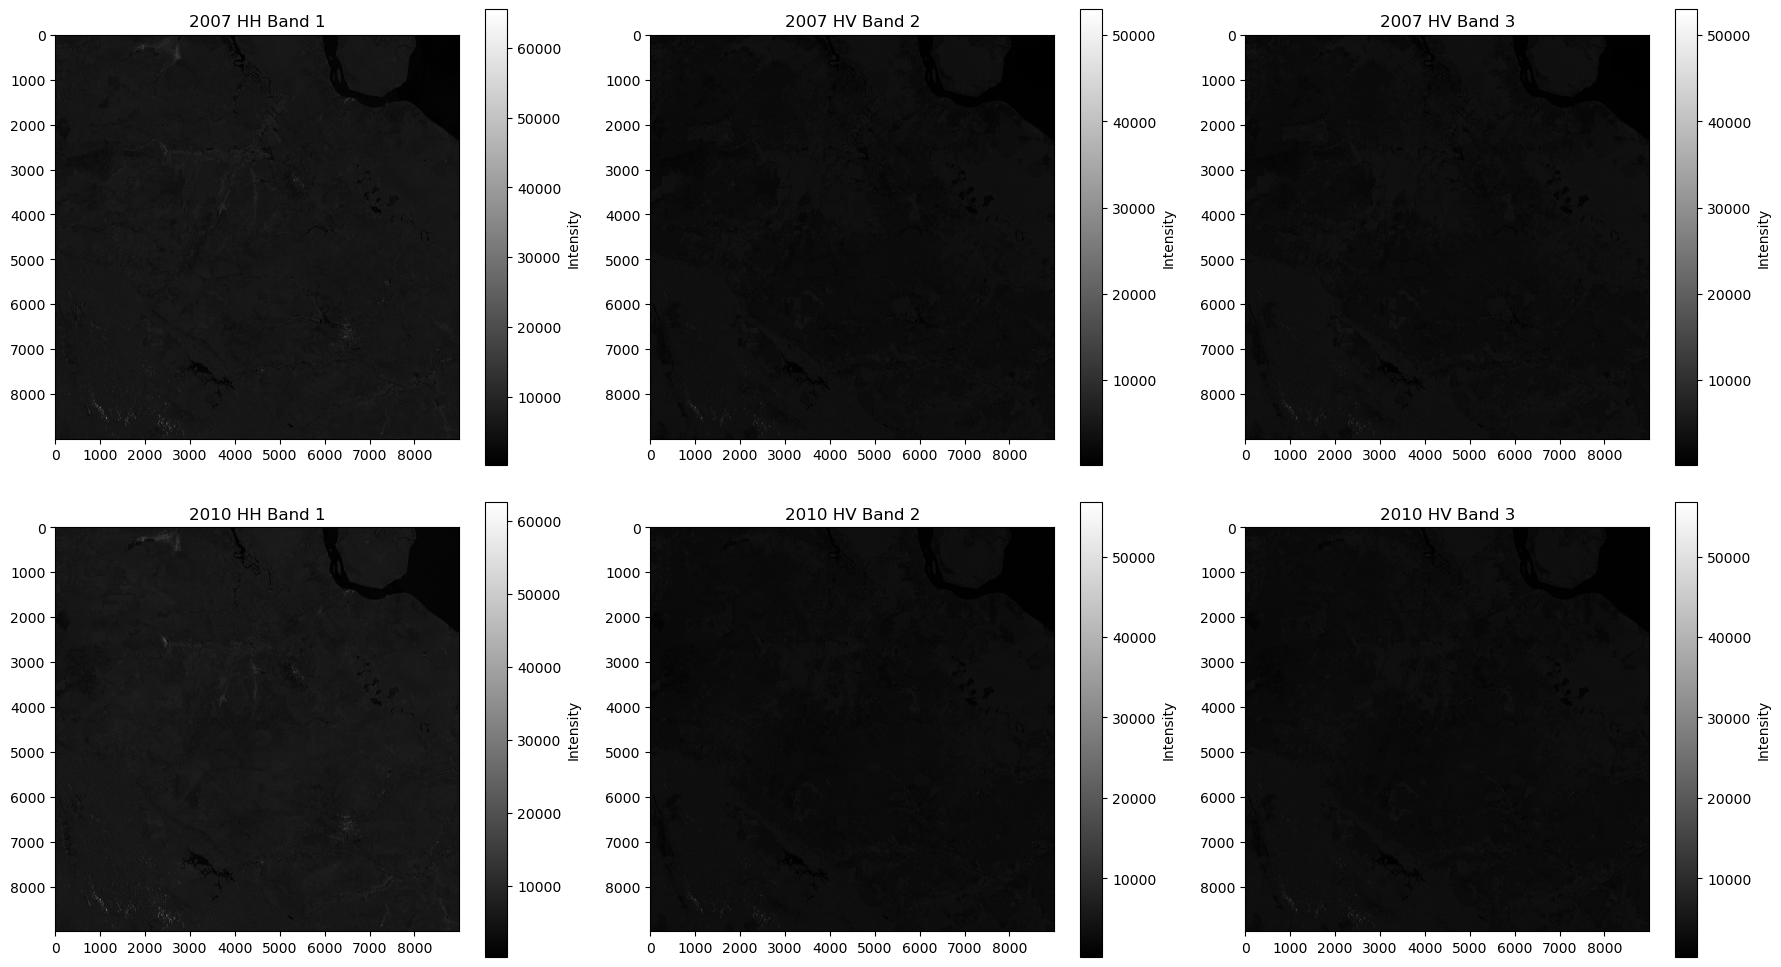

In [ ]:
# Normalize 2007 composite
rgb_composite_2007 = (rgb_composite_2007 - np.min(rgb_composite_2007)) / (np.max(rgb_composite_2007) - np.min(rgb_composite_2007))

# Normalize 2010 composite
rgb_composite_2010 = (rgb_composite_2010 - np.min(rgb_composite_2010)) / (np.max(rgb_composite_2010) - np.min(rgb_composite_2010))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
# Plot 2007 composite
im1 = ax1.imshow(rgb_composite_2007)
ax1.set_title("2007 Color Composite of HH and HV Images")
# Plot 2010 composite
im2 = ax2.imshow(rgb_composite_2010)
ax2.set_title("2010 Color Composite of HH and HV Images")

plt.tight_layout()
plt.show()

The overall darkness makes interpretation difficult. Adjust the contrast.

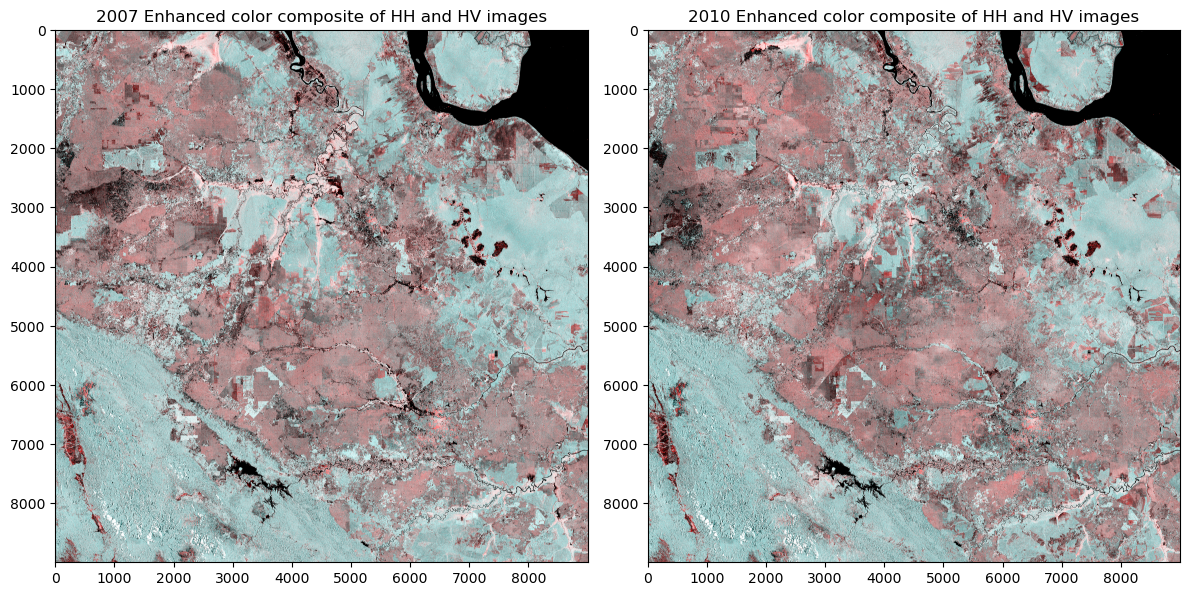

In [ ]:
# Function to enhance the RGB composite
def enhance_composite(rgb_composite, gamma=0.5):
    # Apply gamma correction
    rgb_composite_gamma = np.zeros_like(rgb_composite)
    for i in range(3): 
        rgb_composite_gamma[:, :, i] = np.power(rgb_composite[:, :, i], gamma)

    # Calculate percentiles for contrast stretching
    p2_r, p98_r = np.percentile(rgb_composite_gamma[:, :, 0], (5, 95))
    p2_g, p98_g = np.percentile(rgb_composite_gamma[:, :, 1], (5, 95))
    p2_b, p98_b = np.percentile(rgb_composite_gamma[:, :, 2], (5, 95))

    # Perform contrast stretching
    r_stretched = np.clip((rgb_composite_gamma[:, :, 0] - p2_r) / (p98_r - p2_r), 0, 1)
    g_stretched = np.clip((rgb_composite_gamma[:, :, 1] - p2_g) / (p98_g - p2_g), 0, 1)
    b_stretched = np.clip((rgb_composite_gamma[:, :, 2] - p2_b) / (p98_b - p2_b), 0, 1)

    # Combine stretched channels back into an RGB image
    return np.dstack((r_stretched, g_stretched, b_stretched))

# Enhance both 2007 and 2010 composites
rgb_composite_enhanced_2007 = enhance_composite(rgb_composite_2007)
rgb_composite_enhanced_2010 = enhance_composite(rgb_composite_2010)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
# Plot 2007 enhanced composite
im1 = ax1.imshow(rgb_composite_enhanced_2007)
ax1.set_title("2007 Enhanced color composite of HH and HV images")
# Plot 2010 enhanced composite
im2 = ax2.imshow(rgb_composite_enhanced_2010)
ax2.set_title("2010 Enhanced color composite of HH and HV images")

plt.tight_layout()
plt.show()

Color compositing and contrast adjustment allow interpretation of land cover and land use in the target area. The red region indicates greater scattering of HH compared to HV, and the blue-white region indicates greater scattering of HV compared to HH.

#### 1.2.1.2. Example of typical land cover interpretation

Land cover can be interpreted from image patterns in ALOS-2/PALSAR-2 color composite images.[Basic principles are explained in the linked explanation「Polarization and Scattering Mechanisms」for more information.](https://www.earthdata.nasa.gov/learn/earth-observation-data-basics/sar).Interpretation of image patterns can be used to determine the distribution of land use and land cover. An example of interpretation is shown below.

In this exercise, The blue-white area represents the forest, Red areas are sparse vegetation,We note in particular that it represents an oil palm plantation.

![](hhhv_des.png)

#### 1.2.1.3. Analysis of oil palm plantation expansion using color composite images of time series data

Visualize the annual data for even more periods here, Let's analyze the dynamics of oil palm plantations in this area.

In [ ]:
rgb_composite = list()
rgb_composite_enhanced = list()

for YYYY in [2007, 2010, 2015, 2020]:
    hh = rasterio.open('Alos_2_' + str(YYYY) + '_HH.tif').read(1)
    hv = rasterio.open('Alos_2_' + str(YYYY) + '_HV.tif').read(1)
    rgb_composite_enhanced.append(enhance_composite(np.dstack((hh, hv, hv))))


In [ ]:
import matplotlib.pyplot as plt

YYYY = [2007, 2010, 2015, 2020]

# Create subplots
fig, axes = plt.subplots(1, len(YYYY), figsize=(12, 24))

# Iterate over axes and data to plot
for ax, year, image in zip(axes, YYYY, rgb_composite_enhanced):
    ax.imshow(image)
    ax.set_title(str(year))
    # Remove axis labels
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

Let's take a closer look at the area slightly north of the center of the western edge of the region.

|    Vegetation to oil palm plantation          | 2007                                  | 2010                | 2015                   | 2020 |
|-------------------|----------------------------------|-------------------------------|---------------------------------|-----------------------------------------|
|**ALOS-2/PALSAR-2 composite image   (R:HH G:HV B:HV)**        | ![07rgb.png](07rgb.png) | ![10rgb.png](10rgb.png) |![15rgb.png](15rgb.png) | ![20rgb.png](20rgb.png) |
| **Satellite photo by Google Earth**       | ![07gg.png](07gg.png)      | ![10gg.png](10gg.png) | ![15gg.png](15gg.png) | ![20gg.png](20gg.png) |

Around the center of this region（latitude 1.26, longitude around 100.10）on Google Earth.**High-resolution images from December 2013** is included in the collection, so take a look at it,You can see that palm palms are neatly arranged in rows. It can be inferred that the transition of the area that was forest cover in 2007 (blue-white area) was developed as an oil palm plantation over a period of more than 10 years.

![image.png](oilpalm_1.png)

Also, for the black region in 2010 (small scatter for both HV/HH; latitude 1.273, longitude around 100.094) region,**High-resolution images from June 2013** is recorded, so the area is partially left after it has been reclaimed, and oil palms can be seen scattered throughout the area. Given that it takes several years for oil palm to grow to the point where it can produce palm oil, the PALSAR-2 data is expected to capture the transition of oil palm growth.

![image.png](oilpalm_2.png)

#### Memory management

Free memory of unnecessary data.

In [ ]:
del rgb_composite_enhanced, hv, hh, rgb_composite_2007, rgb_composite_2010, rgb_composite_enhanced_2007, rgb_composite_enhanced_2010 

## 1.3. Change detection analysis based on analysis of 2-time period data

In this section,By analyzing the HH/HV scattering intensities during the two periods with Change Vector Analysis, the procedure for detecting and analyzing changes will be practiced. In the previous section, we analyzed land cover and land use changes by comparing color tones and patterns in color composite images from year to year.

Change vector analysisis a method used to analyze changes in 2D data points and is an effective method for analyzing HH/HV changes in PALSAR-2. In this section, we will deepen our understanding of the procedures and interpretations by analyzing the 2007 and 2010 annual composite data.[Reference 1](https://web.pdx.edu/~nauna/week5.pdf), [Reference 2](https://www.isprs.org/proceedings/xxxiv/part1/paper/00014.pdf)

### 1.3.1. Conversion from DN values to backscatter coefficients

In the previous section, the pixel value（DN; digital number）was used for visualization as is, but for rigorous data analysis, it is desirable to convert the pixel values ​​into backscattering coefficients. The conversion is done using the following formula:

$$ \gamma^{0} = 10 log_{10} <DN^2> + CF $$

Note that, <> represents averaging for noise reduction and -83.0 dB is used for CF. [Global 25m Resolution PALSAR-2/PALSAR Mosaic (Ver. 2.4.0) Dataset Instructions](https://www.eorc.jaxa.jp/ALOS/jp/dataset/pdf/DatasetDescription_PALSAR2_Mosaic_ver240_ja.pdf). A coding example is shown below.

In [ ]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

def calibrate_ima(image):
    return 10 * np.log10(image ** 2) - 83.0

def ima_cal(file_path):
    with rasterio.open(file_path) as src:
        original = src.read(1).astype('float32')
        calibrated = calibrate_ima(original)
    return original, calibrated

hh_2007_path = "Alos_2_2007_HH.tif" 
hh_2010_path = "Alos_2_2010_HH.tif"
hv_2007_path = "Alos_2_2007_HV.tif"
hv_2010_path = "Alos_2_2010_HV.tif"

hh_2007_raw, hh_2007_cal = ima_cal(hh_2007_path)
hh_2010_raw, hh_2010_cal = ima_cal(hh_2010_path)
hv_2007_raw, hv_2007_cal = ima_cal(hv_2007_path)
hv_2010_raw, hv_2010_cal = ima_cal(hv_2010_path)

fig, axs = plt.subplots(4, 2, figsize=(12, 16))

axs[0, 0].imshow(hh_2007_raw, cmap='gray')
axs[0, 0].set_title('Year 2007 HH (Original)')
axs[0, 1].imshow(hh_2007_cal, cmap='gray')
axs[0, 1].set_title('Year 2007 HH (Calibrated)')

axs[1, 0].imshow(hh_2010_raw, cmap='gray')
axs[1, 0].set_title('Year 2010 HH (Original)')
axs[1, 1].imshow(hh_2010_cal, cmap='gray')
axs[1, 1].set_title('Year 2010 HH (Calibrated)')

axs[2, 0].imshow(hv_2007_raw, cmap='gray')
axs[2, 0].set_title('Year 2007 HV (Original)')
axs[2, 1].imshow(hv_2007_cal, cmap='gray')
axs[2, 1].set_title('Year 2007 HV (Calibrated)')

axs[3, 0].imshow(hv_2010_raw, cmap='gray')
axs[3, 0].set_title('Year 2010 HV (Original)')
axs[3, 1].imshow(hv_2010_cal, cmap='gray')
axs[3, 1].set_title('Year 2010 HV (Calibrated)')

for i in range(4):
    fig.colorbar(axs[i, 0].imshow(hh_2007_raw, cmap='gray'), ax=axs[i, 0], orientation='vertical', label='DN')
    fig.colorbar(axs[i, 1].imshow(hh_2007_cal, cmap='gray'), ax=axs[i, 1], orientation='vertical', label='Calibrated dB')

plt.tight_layout()
plt.show()

##### (Optional) If the conversion process takes a long time

The above process may take some time depending on the performance of your PC. In that case, stop the process and execute the following cells.

In [ ]:
with rasterio.open('2007HHcalibrated5_image.tif') as src:
    hh_2007_cal = src.read(1)
with rasterio.open('2007HVcalibrated5_image.tif') as src:
    hv_2007_cal = src.read(1)
    
# Load ALOS-2 2010
with rasterio.open('2010HHcalibrated5_image.tif') as src:
    hh_2010_cal = src.read(1)
with rasterio.open('2010HVcalibrated5_image.tif') as src:
    hv_2010_cal = src.read(1)


.

### Mid-term changes, such as 3 years, from 2007 to 2010.

![st_term_0710_rgb.png](st_term_0710_rgb.png)

 ### Long-term changes, such as 10 years, from 2010 to 2020.
![lt_term1020_rgb.png](lt_term1020_rgb.png)


1. **Short-Mid-Term Changes (1–3 Years)**
In the initial stages, the conversion from forest to oil palm plantation involves dramatic land-use changes, including clearing natural forest cover, preparing the land, and establishing new crops
2. **Long-Term Changes (10 Years)** Over a decade, the area transforms into a mature oil palm plantation.
.

### 1.3.2. HH/HV change analysis

Calculate the difference in image data to analyze the change from 2007 to 2010 for each HH/HV.

In [ ]:
delta_bandhv_cal = hv_2010_cal - hv_2007_cal
delta_bandhh_cal = hh_2010_cal - hh_2007_cal

fig, axs = plt.subplots(1, 2, figsize=(12, 16))

axs[0].imshow(delta_bandhv_cal, cmap='gray')
axs[0].set_title('HV change (2010 - 2007)')
axs[1].imshow(delta_bandhh_cal, cmap='gray')
axs[1].set_title('HH change (2010 - 2007)')
plt.tight_layout()
plt.show()

Darker areas of pixel brightness represent a decrease, Bright areas indicate an increase. A decrease in HV indicates a decrease in volume scattering,It is believed that the forest has been cut down. The pixel values in this difference image usually follow a normal distribution, Approximately 2.5% on each side was considered a significant change, The classification of $ \mu \pm 2 * \sigma $ as the threshold can be used to detect changes.This procedure will be implemented with a different indicator, as it will be practiced in another indicator.

### 1.3.3. Change vector analysis (CVA) Data analysis

The changes that appear in the difference image calculated in the previous section can be expressed as vectors in the two-dimensional space of HH/HV pairs for each pixel.The figure below shows an example where HV has decreased significantly while HH has decreased slightly. The following code cell calculates the length of the change vector at each pixel, expressed as magnitude, and the direction as angle.

![image.png](HHHV.png)

In [ ]:
magnitude = np.sqrt(delta_bandhv_cal**2 + delta_bandhh_cal**2)
angle = np.arctan2(delta_bandhv_cal, delta_bandhh_cal) #Radians: When using trigonometric functions like arctan or atan2, the default output is often in radians, where 00 to 2𝜋2π radians (approximately 00 to 6.286.28) covers the full circular range of angles.

Visualize the calculation results.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

norm_magnitude = mcolors.Normalize(vmin=0, vmax=10)

fig, axs = plt.subplots(1, 2, figsize=(18, 6))

im1 = axs[0].imshow(magnitude, cmap='gray', norm=norm_magnitude)
axs[0].set_title("Magnitude of change")
cbar1 = fig.colorbar(im1, ax=axs[0])
cbar1.set_label("Intensity")

im2 = axs[1].imshow(angle, cmap='hsv')
axs[1].set_title("Direction (Angle of change)")
cbar2 = fig.colorbar(im2, ax=axs[1])
cbar2.set_label("Radians")

plt.tight_layout()
plt.show()

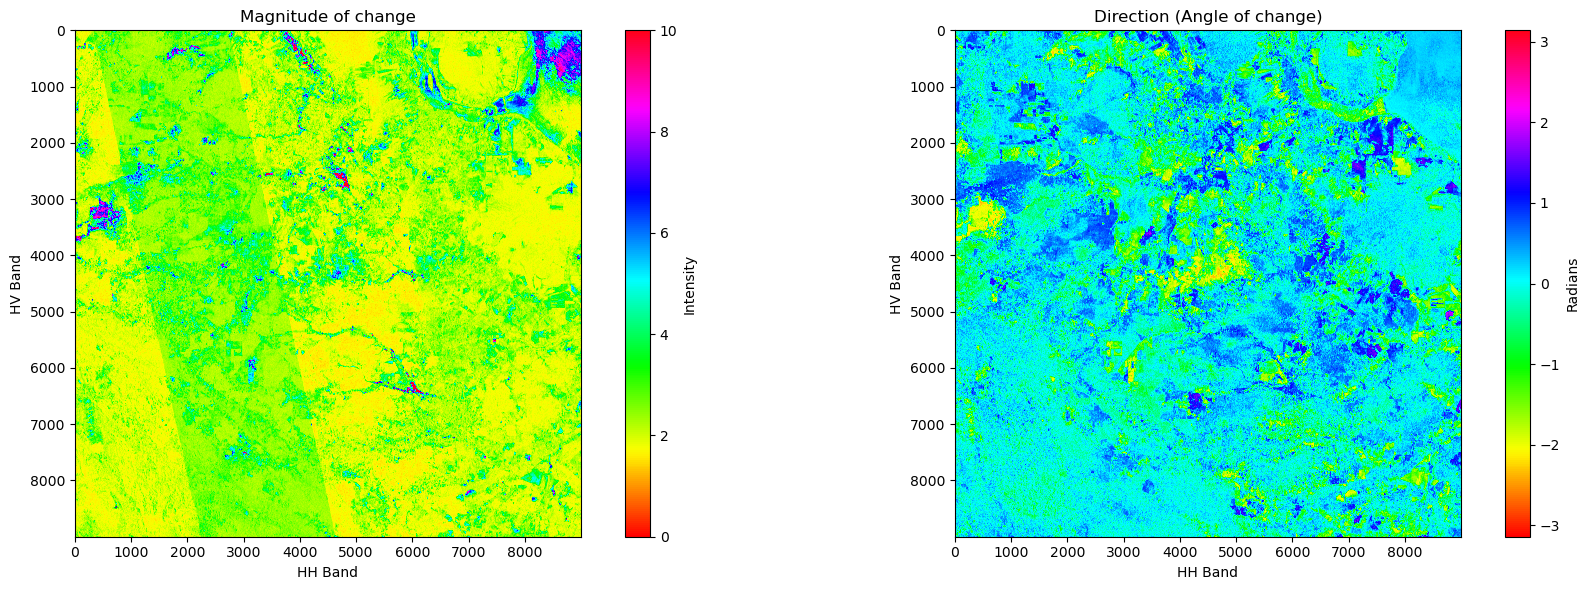

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

norm_magnitude = mcolors.Normalize(vmin=0, vmax=10)

fig, axs = plt.subplots(1, 2, figsize=(18, 6))

im1 = axs[0].imshow(magnitude, cmap='hsv', norm=norm_magnitude)
axs[0].set_title("Magnitude of change")
axs[0].set_xlabel("HH Band")
axs[0].set_ylabel("HV Band")
cbar1 = fig.colorbar(im1, ax=axs[0])
cbar1.set_label("Intensity")

im2 = axs[1].imshow(angle, cmap='hsv')
axs[1].set_title("Direction (Angle of change)")
axs[1].set_xlabel("HH Band")
axs[1].set_ylabel("HV Band")
cbar2 = fig.colorbar(im2, ax=axs[1])
cbar2.set_label("Radians")

plt.tight_layout()
plt.show()

Several areas with particularly high pixel values appeared in the magnitude image.Since MAGNITUDE generally follows a normal distribution, it seems possible to consider the edges of the distribution as significant changes.Therefore, we use $\mu + 2 * \sigma $ as the threshold to extract regions with significant changes.

In [ ]:
# Histograms

import matplotlib.pyplot as plt
import numpy as np

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Generate and plot the histogram
data = np.random.choice(magnitude.ravel(), size=10000, replace=False)
ax.hist(data, bins=100, color='blue', edgecolor='black', alpha=0.7)

# Set plot title and labels
ax.set_title('Histogram of Magnitude', fontsize=14)
ax.set_xlabel('Magnitude', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

# Improve layout
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Calculate the threshold for significant changes
threshold = np.mean(magnitude) + 2 * np.std(magnitude)
significant_change = np.where(magnitude > threshold, 1, 0)

# Define a discrete colormap for significant changes
cmap = ListedColormap(['black', 'red'])

# Create the subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot significant changes
im1 = axs[0].imshow(significant_change, cmap=cmap, origin='upper')
axs[0].set_title('Significant Changes', fontsize=14)

# Add a colorbar for significant changes
cbar1 = fig.colorbar(im1, ax=axs[0], ticks=[0, 1])
cbar1.ax.set_yticklabels(['No Change', 'Change'])
cbar1.set_label('Change', fontsize=12)

# Plot direction (angle of change)
im2 = axs[1].imshow(angle / 3.14 * 180, cmap='hsv', origin='upper')
axs[1].set_title("Angle of Change Vector", fontsize=14)

# Add a colorbar for direction
cbar2 = fig.colorbar(im2, ax=axs[1])
cbar2.set_label("Degree", fontsize=12)

# Improve layout
plt.tight_layout()

# Show the plot
plt.show()


### 1.3.4. Analysis of CVA analysis results

Ideally, the data should be overlaid using a GIS or similar tool for analysis, but in this exercise, the result images will be compared for analysis.

![image.png](magnitude.png)
|  Location |   Google Earth satellite image (2007)  |  Google Earth satellite image  (2010)  | Explanation  | 
| ---- | ---- |---- | ---- |
| a |  ![image.png](a1.png) |  ![image.png](a2.png) | Scattering decreased for both HH and HV, but the decrease in HV was more significant, suggesting that forests were loss between 2007 and 2010. |
| b |  ![image.png](b1.png)  | ![image.png](b2.png)  | Scattering increased for both HH and HV. It is thought to be a combined effect of deforestation and increased construction. |
|c|![image.png](c1.png)|![image.png](b2.png)|same as above|

## 1.4. Advantages and Uses of this Exercise Procedure

### Why go through  complicated steps when you can find it all on Google Earth?

- In this exercise **Fortunately**, the images included are just for reference; for other periods and areas, they are purchased from MAXAR or Airbus.Even archiving costs 3,000-5,000 yen per kilometer, so it is not realistic to use it for large-area analysis such as oil palm plantations.If you want to analyze past transitions, the annual composite data used in this exercise is easy to use and can be used free of charge (Commercial use is also acceptable?).
- Processing high-resolution images such as those included in Google Earth requires a lot of computer resources. The analysis procedure demonstrated in this exercise **is efficient and requires only minimal computation**.

### Ideas for using the above benefits

- Wide-area change detection screening: A system that continuously processes the latest observation data to detect changes and provides automatic notifications, unlike the method used in this exercise, which relies on past data.
- Analysis of the management history of oil palm plantations: By analyzing past data,  we can identify when plantations were established, the growth of oil palms, and profile the history of a large number of plantations.
